Credits to Elissaios Sarmas for the code, which was adapted for use on this dataset (credits to Xiaomin Chang). Code can be found here: https://github.com/ElissaiosSarmas/Transfer-learning-strategies-for-solar-power-forecasting-under-data-scarcity

In [1]:
# Clear any logs from previous runs
!rm -r ./LSTM_w_TL_2/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
import datetime, os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras_layer_normalization import LayerNormalization
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import Input,Model
from tensorflow.keras.models import load_model
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK, STATUS_FAIL, space_eval
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [3]:
path = "C:/work/Honours code/Datasets/PV-Output-Datasets-main/1 gazbray.csv"

p2 = pd.read_csv(path, header=0, sep= ';')

In [4]:
p2_copy = p2.copy()
p2_copy['Date'] = pd.to_datetime(p2['Date'], format='%d/%m/%Y')

# p2_copy.drop(['period_end'], axis=1, inplace=True)

# dropping columns that are not needed
# p2_copy.drop(['Unnamed: 0', 'period_x', 'period_y', '_id_x', '_id_y'], axis=1, inplace=True)

# make the date the first column
date = p2_copy.pop('Date')
p2_copy.insert(0, 'Date', date)

# extract the hour and month from the timestamp
# p2_copy['hour'] = pd.to_datetime(p2_copy['Date']).dt.hour
# p2_copy['month'] = pd.to_datetime(p2_copy['Date']).dt.month

# convert the Cond colmn to dummy variables
p2_copy['Cond'] = p2_copy['Cond'].astype('category').cat.codes

In [5]:
# Print the mappings for the Cond column
categories = p2['Cond'].astype('category').cat.categories
category_code_mapping = {code: category for code, category in enumerate(categories)}
print(category_code_mapping)

{0: 'Cloudy', 1: 'Fine', 2: 'Showers'}


In [6]:
p2_copy

,Date,Generated,Exported,subGen,mmGen,subExp,mmExp,Cond,Temp med
0,2015-07-01,14.5,11.0,2.3,15.65,1,11.5,0,15.5
1,2015-07-02,16.8,12.0,2.3,17.70,3,13.5,0,13.0
2,2015-07-03,18.6,15.0,1.8,18.40,-2,14.0,1,12.5
3,2015-07-04,18.2,13.0,-0.4,17.90,0,13.0,0,12.5
4,2015-07-05,17.6,13.0,-0.6,18.00,-1,12.5,0,13.5
...,...,...,...,...,...,...,...,...,...
1456,2019-06-26,5.7,2.0,-3.2,8.65,4,4.0,2,17.5
1457,2019-06-27,11.6,6.0,5.9,12.40,2,7.0,2,18.0
1458,2019-06-28,13.2,8.0,1.6,13.25,-1,7.5,0,17.0
1459,2019-06-29,13.3,7.0,0.1,14.00,0,7.0,0,16.5


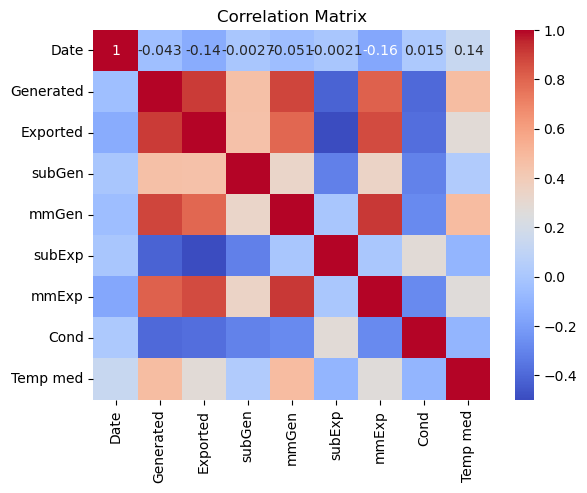

In [7]:
corr_matrix = p2_copy.corr()
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

I will need to drop one variable to match the features for the other datasets (10). Probably will drop Exported, as it seems to be highly correlated with Generated and seems less relevant than other variables.

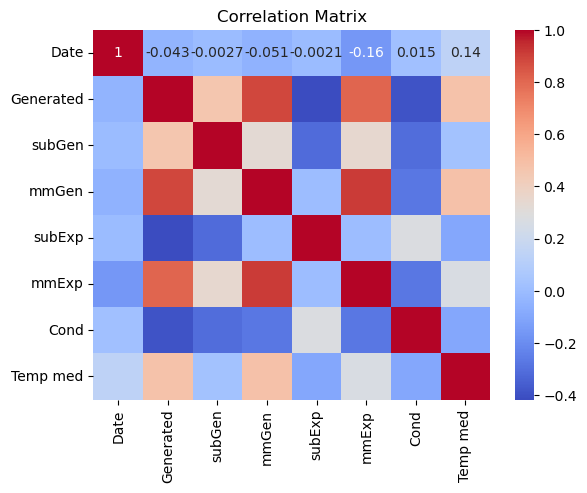

In [8]:
cols_to_keep = ['Date', 'Generated', 'subGen', 'mmGen', 'subExp', 'mmExp', 'Cond', 'Temp med']
corr_plot2 = p2_copy[cols_to_keep]
corr_mat2 = corr_plot2.corr()
# Plot the correlation matrix
sns.heatmap(corr_mat2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
p2_copy_2 = p2_copy.drop(['Exported'], axis=1)

In [10]:

# Perform One-Hot-Encoding for Months and Sin-Cos Similarities for Hours
data = p2_copy_2
data['Date'] = pd.to_numeric(data['Date'])
#data = pd.get_dummies(data, columns=['month'])
data.loc[:,'sin_hour'] = np.sin(2*np.pi*data['Date']/24)
data.loc[:,'cos_hour'] = np.cos(2*np.pi*data['Date']/24)

print("Total Entries =", len(data))

Total Entries = 1461


In [11]:
# Shaping data for LSTM input
def split_sequences(sequences, n_steps, n_outputs, only_production, validation_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + n_outputs > len(sequences):
            break
        # gather input and output parts of the pattern
        if only_production==True:
            seq_x, seq_y = sequences[i:end_ix, -1], sequences[end_ix:(end_ix+n_outputs), -1]
        else:
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:(end_ix+n_outputs), -1]
            
        X.append(seq_x)
        y.append(seq_y)
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [12]:
def unique_shapes(x, y, lag_, n_features_, num_of_outputs_, only_production, validation_split):
    unique_shapes = []
    for k in range(len(x)):
        if only_production==True:
            if (x[k].shape == (lag,)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)
        else:
            if (x[k].shape == (lag_, n_features_)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)       
    x = x[unique_shapes]
    y = y[unique_shapes]
    x = np.stack(x)
    y = np.stack(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [13]:
cols = data.columns.tolist()
cols

['Date',
 'Generated',
 'subGen',
 'mmGen',
 'subExp',
 'mmExp',
 'Cond',
 'Temp med',
 'sin_hour',
 'cos_hour']

In [14]:
# Select the columns that you want to use as features
cols = ['Date',
 'subGen',
 'mmGen',
 'subExp',
 'mmExp',
 'Cond',
 'Temp med',
 'sin_hour',
 'cos_hour',
 'Generated']

# Set to True if using only the production, else to False
only_production = False
# Splitting factor for training set and test set
split = 0.4

# Select the lag variable, the number of features (must be same with cols selected) and the horizon
lag = 5
n_features = len(cols)
num_of_outputs = 1

Padding the data to match the domain dataset

In [15]:
timesteps = 5
features = 10
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_array = data['Date'].values
# flatten the data
data_array = data_array.reshape(-1)
total_features = ((len(data_array) // (timesteps * features)) + 1) * (timesteps * features)
# calculate the padding
padding = total_features - len(data_array)
# pad the data
data_padded = np.pad(data_array, (0, padding), 'constant')

# Reshape the data
data_padded = data_padded.reshape(-1, timesteps, features)

print(data_padded.shape)

(30, 5, 10)


In [17]:
# Scale data seperately
from sklearn.preprocessing import MinMaxScaler

if only_production == True:
    data_ = data_['SystemProduction']
    train = data_.iloc[:int(len(data_)*split_),]
    test = data_.iloc[int(len(data_)*split_):,]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1, 1))
    test = scaler.fit_transform(test.values.reshape(-1, 1))
else:
    # convert numpy array to pandas dataframe
    # data = pd.DataFrame(data_padded.reshape(-1, features))
    # flatten the data
    data = data_padded.reshape(-1, len(cols))
    print(data.shape)
    data = pd.DataFrame(data, columns=cols)
    data = data[cols]
    train = data.iloc[:int(len(data)*split),:]
    test = data.iloc[int(len(data)*split):,]
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)

(150, 10)


In [18]:
# Create the input for LSTM: x(batch_size, lag, features), y(batch_size,)

x_train, x_val, y_train, y_val = split_sequences(train, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = split_sequences(test, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)

x_train, x_val, y_train, y_val = unique_shapes(x_train, y_train, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = unique_shapes(x_test, y_test, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)


# Reshape for only_production case
if only_production:
    x_train = x_train.reshape((x_train.shape[0], lag, 1))
    x_test = x_test.reshape((x_test.shape[0], lag, 1))
else:
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
# Print the shapes
print("Size of Train / Test =", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Size of Train / Test = (19, 5, 10) (19, 1) (30, 5, 10) (30, 1)


In [19]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))



base_model_path = "C:/work/Honours code/Transfer learning/LSTM/LSTM_base.h5"


In [20]:

def createModel():

    # BI-LSTM Model Architecture

    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    model = Model(inputs=model.inputs, outputs=output)
    #model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = model(inputs, training=False)
    # x = model(inputs, training=False)
    print("Input shape:", x_train.shape)
    x = Bidirectional(LSTM(32, activation="relu", return_sequences=False))(x)
    x = Dropout(0.36)(x)

    # x = Dense(500, activation="relu")(x)
    outputs  = Dense(1)(x)

    model = Model(inputs, outputs)

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model.summary()

    return model

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from keras.layers import TFSMLayer
from tensorflow.keras import backend as K
import h5py
import os
import time
timestamp = int(time.time())
true_values = []
predicted_values = []
model_path = "LSTM_model_2.h5"
K.clear_session()
def fit_predict_stats(model):
    # Early stopping property
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    tb = TensorBoard(log_dir='logs')
    experiment_name = 'run_3'
    log_dir = f'./logs/{experiment_name}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    # Model fine-tuning
    model.trainable = True
    model.layers[0].trainable = True
    model.layers[1].trainable = True
    optimizer = Adam(learning_rate=0.0001) # Decreasing the learning rate to prevent overfitting
    # optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    history = model.fit(x_train, y_train, epochs=20, validation_split=0.1, batch_size=128, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    if os.path.exists(model_path):
        
    # Load the model
        tf.debugging.set_log_device_placement(True)
        model = load_model(model_path)
    else:
        # Model file does not exist, so save the model
        
        # Fit the model
        
        model.save(model_path, overwrite=True)


    
    # summarize history for MAE and MSE
    # plt.plot(history['loss'])
    # plt.plot(history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('Model MSE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # plt.figure()
    # plt.plot(history['mae'])
    # plt.plot(history['val_mae'])
    # plt.title('Model MAE')
    # plt.ylabel('MAE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # Metrics on scaled data
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    y_pred = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    # print('Train Scaled RMSE: {}'.format(rmse))
    # print('Train Scaled MAE: {}'.format(mae))
    # print('Train Scaled R2 Score: ', r2_score(y_train, y_pred)*100)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # print('Test Scaled RMSE: {}'.format(rmse))
    # print('Test Scaled MAE: {}'.format(mae))
    # print('Test Scaled R2 Score: ',r2_score(y_test, y_pred)*100)


    
    # Metrics on original data
    true = []
    hat = []
    range_ = [0]
    # range_ = list(range(6))

    for i,j in zip([[x_train,y_train],[x_test,y_test]],['Train','Test']):
        # make a prediction
        yhat = model.predict(i[0])
        if yhat.shape == (yhat.shape[0],):
            yhat = yhat.reshape((yhat.shape[0],1))  
      
        y_hat = []
        for k in range(len(yhat)):
            if k == 0:
                for l in range_:
                    y_hat.append(yhat[k,l])
            else:
                y_hat.append(yhat[k,-1])
        
        y_hat = np.stack(y_hat)
        y_hat = y_hat.reshape((y_hat.shape[0],1))

        ### trying to resolve the issue of different shapes
        total_elements = np.product(i[0].shape)
        lag = i[0].shape[1]
        n_features = i[0].shape[2]
        print("Total elements in data:", total_elements)
        ###
        
        i[0] = i[0].reshape((i[0].shape[0],lag,n_features))
        
        x_hat = []
        for k in range(len(i[0])):
            if k == 0:
                x_hat.append(i[0][k])
            elif k!= 0:
                x_hat.append(i[0][k][-1,:])
        
        x_hat = np.vstack(x_hat)
        
        initial_x_hat_shape = x_hat.shape[0]
        initial_y_hat_shape = y_hat.shape[0]
        
        print(x_hat.shape)
        print(y_hat.shape)
        
        if x_hat.shape[0]-y_hat.shape[0] != 0.0:
            if x_hat.shape[0] > y_hat.shape[0]:
                for k in range(x_hat.shape[0]-y_hat.shape[0]):
                    y_hat = np.insert(y_hat, 0, y_hat[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_hat.shape[0]:
                y_hat = y_hat[-int(x_hat.shape[0]-y_hat.shape[0]):,:]
                added_values = False
        
        print(x_hat[:,:-1].shape)
        print(y_hat.shape)
        
        # invert scaling for forecast
        if only_production==True:
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
        else:    
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            
        # invert scaling for actual
        y_true = []
        for k in range(len(i[1])):
            if k ==0:
                for l in range_:
                    y_true.append(i[1][k,l])
            else:
                y_true.append(i[1][k,-1])

        y_true = np.stack(y_true)
        y_true = y_true.reshape((y_true.shape[0],1))
        print(y_true.shape)

        initial_y_true_shape = y_true.shape[0]
        
        if x_hat.shape[0]-y_true.shape[0] != 0.0:
            if x_hat.shape[0] > y_true.shape[0]:
                for k in range(x_hat.shape[0]-y_true.shape[0]):
                    y_true = np.insert(y_true, 0, y_true[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_true.shape[0]:
                y_true = y_true[-int(x_hat.shape[0]-y_true.shape[0]):,:]
                added_values = False
                
        if only_production==True:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
        else:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,-1]
        
        true.append(inv_y)
        hat.append(inv_yhat)

        # true_values.append(true)
        # predicted_values.append(hat)
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate MAE
        mae = mean_absolute_error(inv_y, inv_yhat)
        print('Test MAE: %.3f' % mae)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print('Test R2 Score: ',r2)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        print('MAPE', mape)
        # Calculate MBE
        mbe = np.mean(inv_yhat - inv_y)
        print('Test MBE', mbe)
        # Calculate nRMSE
        nRMSE = rmse / np.mean(inv_y)
        print('nRMSE', nRMSE)

        



    mae_list.append(mae)
    rmse_list.append(rmse)
    r_square_list.append(r2)
    mape_list.append(mape)
    mbe_list.append(mbe)
    nRMSE_list.append(nRMSE)



In [22]:
mae_list = []
rmse_list = []
r_square_list = []
mape_list = []
mbe_list = []
nRMSE_list = []
num_iterations = 20
#num_iterations = 2
for i in range(num_iterations):
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)
    model = createModel()
    keras.config.disable_traceback_filtering()
    fit_predict_stats(model)

# sns.set_style("darkgrid")
# for true, hat in zip(true_values, predicted_values):
#     plt.figure()
#     plt.plot(true[1], color="green")
#     plt.plot(hat[1], color="red")
#     plt.savefig('plots/lstm_base_plot.png')
    #plt.show()

print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("R^2:", r_square_list)
print("MAPE:", mape_list)
print("MBE:", mbe_list)
print("nRMSE:", nRMSE_list)

print("Mean MAE:", np.mean(mae_list))
print("Mean RMSE:", np.mean(rmse_list))
print("Mean R^2:", np.mean(r_square_list))
print("Mean MAPE:", np.mean(mape_list))
print("Mean MBE:", np.mean(mbe_list))
print("Mean nRMSE:", np.mean(nRMSE_list))


Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.3354 - mae: 0.5312 - val_loss: 0.4318 - val_mae: 0.5779
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.3477 - mae: 0.5401 - val_loss: 0.3422 - val_mae: 0.5117
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2671 - mae: 0.4594 - val_loss: 0.2646 - val_mae: 0.4464
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1564 - mae: 0.3235 - val_loss: 0.1989 - val_mae: 0.3830
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0999 - mae: 0.2819 - val_loss: 0.1434 - val_mae: 0.3205
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0768 - mae: 0.2238 - val_loss: 0.0982 - val_mae: 0.2594
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1243 - mae: 0.2549 - val_loss: 0.0613 - val_mae: 0.1991
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0421 - mae: 0.1529 - val_loss: 0.0342 - val_mae: 0.1462
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0215 - ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.3347 - mae: 0.5207 - val_loss: 0.4038 - val_mae: 0.5557
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2559 - mae: 0.4570 - val_loss: 0.3530 - val_mae: 0.5172
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.2574 - mae: 0.4444 - val_loss: 0.3060 - val_mae: 0.4789
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2257 - mae: 0.4148 - val_loss: 0.2628 - val_mae: 0.4408
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1651 - mae: 0.3496 - val_loss: 0.2218 - val_mae: 0.4020
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1492 - mae: 0.3411 - val_loss: 0.1835 - val_mae: 0.3621
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1056 - mae: 0.2642 - val_loss: 0.1483 - val_mae: 0.3216
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0963 - mae: 0.2503 - val_loss: 0.1162 - val_mae: 0.2801
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0725 - mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_21 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.1768 - mae: 0.3736 - val_loss: 0.2120 - val_mae: 0.4028
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1381 - mae: 0.3317 - val_loss: 0.1620 - val_mae: 0.3490
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1147 - mae: 0.2777 - val_loss: 0.1178 - val_mae: 0.2943
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0944 - mae: 0.2416 - val_loss: 0.0818 - val_mae: 0.2408
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0453 - mae: 0.1652 - val_loss: 0.0523 - val_mae: 0.1869
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0279 - mae: 0.1238 - val_loss: 0.0300 - val_mae: 0.1333
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0382 - mae: 0.1242 - val_loss: 0.0148 - val_mae: 0.0877
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0159 - mae: 0.1039 - val_loss: 0.0064 - val_mae: 0.0692
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0194 - mae: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_29 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2244 - mae: 0.4114 - val_loss: 0.2724 - val_mae: 0.4453
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2346 - mae: 0.4013 - val_loss: 0.2155 - val_mae: 0.3913
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1277 - mae: 0.2950 - val_loss: 0.1653 - val_mae: 0.3372
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0963 - mae: 0.2289 - val_loss: 0.1212 - val_mae: 0.2865
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0671 - mae: 0.1944 - val_loss: 0.0831 - val_mae: 0.2371
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0313 - mae: 0.1296 - val_loss: 0.0522 - val_mae: 0.1867
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0201 - mae: 0.1097 - val_loss: 0.0297 - val_mae: 0.1371
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0361 - mae: 0.1436 - val_loss: 0.0152 - val_mae: 0.1057
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0445 - m

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_37 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.3351 - mae: 0.5283 - val_loss: 0.3681 - val_mae: 0.5388
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2719 - mae: 0.4821 - val_loss: 0.3069 - val_mae: 0.4904
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2182 - mae: 0.4301 - val_loss: 0.2521 - val_mae: 0.4427
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1679 - mae: 0.3713 - val_loss: 0.2031 - val_mae: 0.3952
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1411 - mae: 0.3335 - val_loss: 0.1596 - val_mae: 0.3479
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1215 - mae: 0.3000 - val_loss: 0.1213 - val_mae: 0.3005
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1055 - mae: 0.2674 - val_loss: 0.0880 - val_mae: 0.2526
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0583 - mae: 0.1976 - val_loss: 0.0602 - val_mae: 0.2048
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0617 - ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_45 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.2136 - mae: 0.3957 - val_loss: 0.2795 - val_mae: 0.4653
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2231 - mae: 0.4251 - val_loss: 0.2170 - val_mae: 0.4065
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1172 - mae: 0.2890 - val_loss: 0.1623 - val_mae: 0.3476
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1178 - mae: 0.2888 - val_loss: 0.1153 - val_mae: 0.2879
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0573 - mae: 0.1911 - val_loss: 0.0767 - val_mae: 0.2286
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0837 - mae: 0.1954 - val_loss: 0.0467 - val_mae: 0.1701
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0622 - mae: 0.1863 - val_loss: 0.0254 - val_mae: 0.1193
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0274 - mae: 0.1148 - val_loss: 0.0122 - val_mae: 0.0895
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0404 - m

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_53 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.1774 - mae: 0.3662 - val_loss: 0.2207 - val_mae: 0.4053
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1304 - mae: 0.3018 - val_loss: 0.1789 - val_mae: 0.3614
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1423 - mae: 0.3077 - val_loss: 0.1411 - val_mae: 0.3168
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0827 - mae: 0.2447 - val_loss: 0.1069 - val_mae: 0.2708
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0829 - mae: 0.2193 - val_loss: 0.0768 - val_mae: 0.2242
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0576 - mae: 0.1641 - val_loss: 0.0515 - val_mae: 0.1827
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0528 - mae: 0.1659 - val_loss: 0.0313 - val_mae: 0.1403
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0446 - mae: 0.1418 - val_loss: 0.0168 - val_mae: 0.1017
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0333 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_61 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.1879 - mae: 0.3944 - val_loss: 0.2806 - val_mae: 0.4612
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2121 - mae: 0.3993 - val_loss: 0.2307 - val_mae: 0.4159
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1585 - mae: 0.3532 - val_loss: 0.1859 - val_mae: 0.3707
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1518 - mae: 0.3305 - val_loss: 0.1468 - val_mae: 0.3261
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0960 - mae: 0.2581 - val_loss: 0.1119 - val_mae: 0.2810
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0545 - mae: 0.1849 - val_loss: 0.0823 - val_mae: 0.2365
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0564 - mae: 0.1840 - val_loss: 0.0570 - val_mae: 0.1915
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0598 - mae: 0.1848 - val_loss: 0.0362 - val_mae: 0.1513
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0182 - mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_69 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.4137 - mae: 0.5999 - val_loss: 0.5030 - val_mae: 0.6335
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.4028 - mae: 0.5852 - val_loss: 0.4208 - val_mae: 0.5776
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.3130 - mae: 0.5127 - val_loss: 0.3452 - val_mae: 0.5211
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2520 - mae: 0.4651 - val_loss: 0.2765 - val_mae: 0.4640
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2063 - mae: 0.3991 - val_loss: 0.2151 - val_mae: 0.4066
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1794 - mae: 0.3837 - val_loss: 0.1610 - val_mae: 0.3486
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1105 - mae: 0.3014 - val_loss: 0.1156 - val_mae: 0.2915
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0682 - mae: 0.2294 - val_loss: 0.0786 - val_mae: 0.2355
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0343 - ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_77 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2194 - mae: 0.4209 - val_loss: 0.2785 - val_mae: 0.4558
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1846 - mae: 0.3619 - val_loss: 0.2171 - val_mae: 0.3987
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1253 - mae: 0.2963 - val_loss: 0.1626 - val_mae: 0.3405
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1156 - mae: 0.2868 - val_loss: 0.1154 - val_mae: 0.2812
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0912 - mae: 0.2404 - val_loss: 0.0753 - val_mae: 0.2229
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0282 - mae: 0.1396 - val_loss: 0.0441 - val_mae: 0.1692
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0335 - mae: 0.1433 - val_loss: 0.0219 - val_mae: 0.1148
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0297 - mae: 0.1303 - val_loss: 0.0092 - val_mae: 0.0865
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0400 - ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_85 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.2919 - mae: 0.4862 - val_loss: 0.3708 - val_mae: 0.5364
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2563 - mae: 0.4558 - val_loss: 0.3028 - val_mae: 0.4823
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1826 - mae: 0.3753 - val_loss: 0.2419 - val_mae: 0.4283
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1542 - mae: 0.3526 - val_loss: 0.1863 - val_mae: 0.3727
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1122 - mae: 0.2973 - val_loss: 0.1365 - val_mae: 0.3150
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0826 - mae: 0.2450 - val_loss: 0.0939 - val_mae: 0.2565
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0525 - mae: 0.1777 - val_loss: 0.0592 - val_mae: 0.1973
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0460 - mae: 0.1598 - val_loss: 0.0325 - val_mae: 0.1439
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0072 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_93 (Functional)      │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.3165 - mae: 0.4897 - val_loss: 0.3603 - val_mae: 0.5193
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2499 - mae: 0.4441 - val_loss: 0.2880 - val_mae: 0.4609
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.2128 - mae: 0.3930 - val_loss: 0.2245 - val_mae: 0.4026
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.1194 - mae: 0.2963 - val_loss: 0.1690 - val_mae: 0.3440
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1354 - mae: 0.3010 - val_loss: 0.1209 - val_mae: 0.2855
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0744 - mae: 0.2253 - val_loss: 0.0806 - val_mae: 0.2333
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0545 - mae: 0.1712 - val_loss: 0.0493 - val_mae: 0.1808
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0573 - mae: 0.1689 - val_loss: 0.0266 - val_mae: 0.1282
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0317

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_101 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.2982 - mae: 0.4916 - val_loss: 0.3994 - val_mae: 0.5509
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2739 - mae: 0.4678 - val_loss: 0.3401 - val_mae: 0.5061
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2201 - mae: 0.4270 - val_loss: 0.2863 - val_mae: 0.4618
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2119 - mae: 0.4036 - val_loss: 0.2352 - val_mae: 0.4157
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1355 - mae: 0.3109 - val_loss: 0.1884 - val_mae: 0.3689
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1504 - mae: 0.3255 - val_loss: 0.1466 - val_mae: 0.3217
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1074 - mae: 0.2619 - val_loss: 0.1094 - val_mae: 0.2735
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0605 - mae: 0.2077 - val_loss: 0.0769 - val_mae: 0.2256
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0610

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_109 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2704 - mae: 0.4620 - val_loss: 0.3024 - val_mae: 0.4788
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2150 - mae: 0.3994 - val_loss: 0.2381 - val_mae: 0.4211
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1619 - mae: 0.3565 - val_loss: 0.1823 - val_mae: 0.3639
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1489 - mae: 0.3300 - val_loss: 0.1344 - val_mae: 0.3070
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1032 - mae: 0.2406 - val_loss: 0.0944 - val_mae: 0.2506
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0798 - mae: 0.2029 - val_loss: 0.0615 - val_mae: 0.2015
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0483 - mae: 0.1786 - val_loss: 0.0364 - val_mae: 0.1529
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0158 - mae: 0.0957 - val_loss: 0.0196 - val_mae: 0.1080
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0197 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_117 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.3093 - mae: 0.5119 - val_loss: 0.3483 - val_mae: 0.5252
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.2673 - mae: 0.4726 - val_loss: 0.2914 - val_mae: 0.4786
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1979 - mae: 0.4080 - val_loss: 0.2401 - val_mae: 0.4324
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2032 - mae: 0.4058 - val_loss: 0.1932 - val_mae: 0.3857
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1266 - mae: 0.3220 - val_loss: 0.1493 - val_mae: 0.3365
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1040 - mae: 0.2790 - val_loss: 0.1098 - val_mae: 0.2855
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0775 - mae: 0.2251 - val_loss: 0.0749 - val_mae: 0.2317
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0624 - mae: 0.1894 - val_loss: 0.0459 - val_mae: 0.1762
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0224

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_125 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3760 - mae: 0.5479 - val_loss: 0.4590 - val_mae: 0.5902
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2771 - mae: 0.4773 - val_loss: 0.3870 - val_mae: 0.5385
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.2828 - mae: 0.4592 - val_loss: 0.3209 - val_mae: 0.4865
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2213 - mae: 0.4100 - val_loss: 0.2604 - val_mae: 0.4339
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1865 - mae: 0.3844 - val_loss: 0.2061 - val_mae: 0.3810
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1352 - mae: 0.3024 - val_loss: 0.1580 - val_mae: 0.3288
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1202 - mae: 0.2673 - val_loss: 0.1158 - val_mae: 0.2825
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0698 - mae: 0.2181 - val_loss: 0.0800 - val_mae: 0.2349
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0330

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_133 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3285 - mae: 0.5201 - val_loss: 0.3962 - val_mae: 0.5512
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2834 - mae: 0.4764 - val_loss: 0.3413 - val_mae: 0.5095
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2334 - mae: 0.4228 - val_loss: 0.2927 - val_mae: 0.4696
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1726 - mae: 0.3677 - val_loss: 0.2486 - val_mae: 0.4303
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1605 - mae: 0.3550 - val_loss: 0.2081 - val_mae: 0.3908
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1451 - mae: 0.3075 - val_loss: 0.1709 - val_mae: 0.3510
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1091 - mae: 0.2711 - val_loss: 0.1369 - val_mae: 0.3105
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1019 - mae: 0.2460 - val_loss: 0.1067 - val_mae: 0.2697
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0566

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_141 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1944 - mae: 0.3998 - val_loss: 0.2542 - val_mae: 0.4342
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1638 - mae: 0.3442 - val_loss: 0.2124 - val_mae: 0.3940
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1102 - mae: 0.2761 - val_loss: 0.1743 - val_mae: 0.3537
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1148 - mae: 0.2940 - val_loss: 0.1395 - val_mae: 0.3126
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0899 - mae: 0.2363 - val_loss: 0.1074 - val_mae: 0.2699
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0948 - mae: 0.2338 - val_loss: 0.0791 - val_mae: 0.2273
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0488 - mae: 0.1675 - val_loss: 0.0548 - val_mae: 0.1881
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0371 - mae: 0.1402 - val_loss: 0.0348 - val_mae: 0.1474
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0257

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_149 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2391 - mae: 0.4237 - val_loss: 0.3118 - val_mae: 0.4824
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2031 - mae: 0.3945 - val_loss: 0.2535 - val_mae: 0.4307
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1609 - mae: 0.3283 - val_loss: 0.2016 - val_mae: 0.3791
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1149 - mae: 0.2727 - val_loss: 0.1559 - val_mae: 0.3274
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1094 - mae: 0.2650 - val_loss: 0.1158 - val_mae: 0.2750
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0780 - mae: 0.2115 - val_loss: 0.0811 - val_mae: 0.2289
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0622 - mae: 0.1939 - val_loss: 0.0526 - val_mae: 0.1818
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0572 - mae: 0.1860 - val_loss: 0.0315 - val_mae: 0.1351
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0217 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_157 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.4049 - mae: 0.5767 - val_loss: 0.4679 - val_mae: 0.5983
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3112 - mae: 0.5096 - val_loss: 0.3970 - val_mae: 0.5478
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2781 - mae: 0.4627 - val_loss: 0.3343 - val_mae: 0.4990
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2204 - mae: 0.4087 - val_loss: 0.2775 - val_mae: 0.4509
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1707 - mae: 0.3584 - val_loss: 0.2274 - val_mae: 0.4040
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1390 - mae: 0.3194 - val_loss: 0.1820 - val_mae: 0.3565
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1409 - mae: 0.2883 - val_loss: 0.1410 - val_mae: 0.3083
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0892 - mae: 0.2650 - val_loss: 0.1044 - val_mae: 0.2643
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0487

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 76153064950579600.000
Test MAE: 71714254939120416.000
Test R2 Score:  0.9568728548671662
MAPE 0.11081766310663003
Test MBE 6.73695910514704e+16
nRMSE 0.0892961946213416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 282912473863019936.000
Test MAE: 67767327458348000.000
Test R2 Score:  0.37629940463336276
MAPE 0.04713404623669007
Test MBE 6.1958568323808664e+16
nRMSE 0.19776339294466438
MAE: [6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767327458348e+16, 6.7767

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_8956\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


In [23]:
#!rm -rf "c:/work/Honours code/Transfer learning/LSTM/logs/"
#!rm -r "c:/work/Honours code/Transfer learning/LSTM/logs/"
%load_ext tensorboard
#%tensorboard --logdir LSTM/logs/
%tensorboard --logdir  "c:/work/Honours code/Transfer learning/LSTM_w_TL_2/logs/run_3/"
#%tensorboard --logdir  "./LSTM/logs/"

%reload_ext tensorboard

In [24]:
%reload_ext tensorboard
#!kill 10060

# Hyperparameter tuning

Code adapted from Xiaomin Chang

In [25]:
base_model_path = "C:/work/Honours code/Transfer learning/LSTM/LSTM_base.h5"

def lstm_training(params):
    new_lstm_units = params['new_lstm_units']
    new_layer_dropout = params['new_layer_dropout']
    initial_validation_split = params['initial_validation_split']
    fine_tuning_validation_split = params['fine_tuning_validation_split']
  
    # create the model
    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    model = Model(inputs=model.inputs, outputs=output)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = model(inputs, training=False)

    x = Bidirectional(LSTM(new_lstm_units, activation="relu", return_sequences=False))(x)
    x = Dropout(new_layer_dropout)(x)
    # x = Dense(500, activation="relu")(x)

    outputs  = Dense(1)(x)

    model = Model(inputs, outputs)

    initial_lr = 0.01

    lr_schedule = ExponentialDecay(
        initial_lr,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True)

    # Compile model
    optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)
    # optimizer = Adam(learning_rate=initial_learning_rate, clipvalue=0.5)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model.summary()

    # return model

    try:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[es])

        # Model fine-tuning
        model.trainable = True
        model.layers[0].trainable = True
        model.layers[1].trainable = True
        optimizer = Adam(learning_rate=0.0001) # Decreasing the learning rate to prevent overfitting
        # optimizer = Adam(learning_rate=lr_schedule)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
        history = model.fit(x_train, y_train, epochs=20, validation_split=fine_tuning_validation_split, batch_size=128, verbose=1, shuffle=True, callbacks=[es]).history

        print(history) 
    
        #loss = history.history['val_loss'][-1]
        loss = np.min(history['val_loss'])
        return {'loss': loss, 'status': STATUS_OK}
    except Exception as e:
        print("Error: {}".format(e))
        print("Params: {}".format(params))
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [26]:
param_grid = {
    #'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    #'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    # 'batch_size': hp.choice('batch_size', [32, 64, 128, 256]), 
    'new_lstm_units': hp.choice('new_lstm_units', [16, 32, 64]),
    # 'lstm_units_2': hp.choice('lstm_units_2', [32, 64, 128]),
    # 'lstm_units_3': hp.choice('lstm_units_3', [64, 128, 256]), 
    'new_layer_dropout': hp.uniform('new_layer_dropout', 0.1, 0.5),
    'initial_validation_split': hp.uniform('validation_split', 0.1, 0.2),
    'fine_tuning_validation_split': hp.uniform('fine_tuning_validation_split', 0.1, 0.2)
    # 'layer1_dropout': hp.uniform('layer1_dropout', 0.1, 0.5),
    # 'layer2_dropout': hp.uniform('layer2_dropout', 0.1, 0.5)
}

In [27]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=20)
best = fmin(lstm_training, param_grid, algo=algo, max_evals=100, pass_expr_memo_ctrl=None, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Model: "functional_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_165 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 0.3435 - mae: 0.5283
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.3435 - mae: 0.5283 - val_loss: 0.0216 - val_mae: 0.1467

Epoch 1/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0137 - mae: 0.1050
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0137 - mae: 0.1050 - val_loss: 0.0055 - val_mae: 0.0693

Epoch 2/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0103 - mae: 0.0898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0103 - mae: 0.0898 - val_loss: 0.0064 - val_mae: 0.0746

Epoch 3/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0103 - mae: 0.0855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0103 - mae: 0.0855 - val_loss: 0.0073 - val_mae: 0.0795

Epoch 4/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0110 - mae: 0.0929
1/1 ━━━━━━━━━━━━━━━━━━

Model: "functional_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_173 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2869 - mae: 0.4761
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2869 - mae: 0.4761 - val_loss: 0.3571 - val_mae: 0.5975

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0669 - mae: 0.1746
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0669 - mae: 0.1746 - val_loss: 0.1223 - val_mae: 0.2930

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0988 - mae: 0.2612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0988 - mae: 0.2612 - val_loss: 0.1204 - val_mae: 0.2905

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0696 - mae: 0.2219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0696 - mae: 0.2219 - val_loss: 0.1186 - val_mae: 0.2880

Epoch 4/20                                                     

Model: "functional_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_181 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4084 - mae: 0.5752
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4084 - mae: 0.5752 - val_loss: 0.1636 - val_mae: 0.4044

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 0.0358 - mae: 0.1406
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.0358 - mae: 0.1406 - val_loss: 0.0497 - val_mae: 0.1797

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0333 - mae: 0.1229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0333 - mae: 0.1229 - val_loss: 0.0472 - val_mae: 0.1750

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0301 - mae: 0.1235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0301 - mae: 0.1235 - val_loss: 0.0449 - val_mae: 0.1703

Epoch 4/20                                                  

Model: "functional_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_189 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2818 - mae: 0.4808
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2818 - mae: 0.4808 - val_loss: 0.0466 - val_mae: 0.2156

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0100 - mae: 0.0774
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0100 - mae: 0.0774 - val_loss: 0.0101 - val_mae: 0.0813

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0132 - mae: 0.0949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0132 - mae: 0.0949 - val_loss: 0.0099 - val_mae: 0.0805

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088 - mae: 0.0794
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0088 - mae: 0.0794 - val_loss: 0.0096 - val_mae: 0.0796

Epoch 4/20                                                     

Model: "functional_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_197 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3689 - mae: 0.5441
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3689 - mae: 0.5441 - val_loss: 0.0548 - val_mae: 0.2339

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0280 - mae: 0.1253
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0280 - mae: 0.1253 - val_loss: 0.0130 - val_mae: 0.0902

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0381 - mae: 0.1449
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0381 - mae: 0.1449 - val_loss: 0.0122 - val_mae: 0.0887

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0128 - mae: 0.1004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0128 - mae: 0.1004 - val_loss: 0.0121 - val_mae: 0.0882

Epoch 4/20                                                       

Model: "functional_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_205 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.3874 - mae: 0.5607
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.3874 - mae: 0.5607 - val_loss: 0.0614 - val_mae: 0.2476

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0250 - mae: 0.0995
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0250 - mae: 0.0995 - val_loss: 0.0120 - val_mae: 0.0891

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0138 - mae: 0.0878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0138 - mae: 0.0878 - val_loss: 0.0113 - val_mae: 0.0874

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0156 - mae: 0.1068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0156 - mae: 0.1068 - val_loss: 0.0111 - val_mae: 0.0867

Epoch 4/20                                                    

Model: "functional_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_213 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3688 - mae: 0.5554
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3688 - mae: 0.5554 - val_loss: 0.2770 - val_mae: 0.5262

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0764 - mae: 0.2173
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0764 - mae: 0.2173 - val_loss: 0.1200 - val_mae: 0.2888

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0393 - mae: 0.1517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0393 - mae: 0.1517 - val_loss: 0.1174 - val_mae: 0.2855

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0598 - mae: 0.1928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0598 - mae: 0.1928 - val_loss: 0.1149 - val_mae: 0.2821

Epoch 4/20                                                     

Model: "functional_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_221 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3187 - mae: 0.4922
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3187 - mae: 0.4922 - val_loss: 0.0141 - val_mae: 0.1185

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0624 - mae: 0.2055
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 0.0624 - mae: 0.2055 - val_loss: 0.0051 - val_mae: 0.0596

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0271 - mae: 0.1357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0271 - mae: 0.1357 - val_loss: 0.0050 - val_mae: 0.0611

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0567 - mae: 0.1889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0567 - mae: 0.1889 - val_loss: 0.0050 - val_mae: 0.0623

Epoch 4/20                                                    

Model: "functional_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_229 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3147 - mae: 0.5009
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3147 - mae: 0.5009 - val_loss: 0.0038 - val_mae: 0.0612

Epoch 1/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0119 - mae: 0.0976
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0119 - mae: 0.0976 - val_loss: 0.0011 - val_mae: 0.0294

Epoch 2/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0156 - mae: 0.1152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0156 - mae: 0.1152 - val_loss: 0.0013 - val_mae: 0.0290

Epoch 3/20                                                                         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0118 - mae: 0.0964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0118 - mae: 0.0964 - val_loss: 0.0016 - val_mae: 0.0341

Epoch 4/20                                                     

Model: "functional_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_237 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3343 - mae: 0.5245
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3343 - mae: 0.5245 - val_loss: 6.9038e-04 - val_mae: 0.0254

Epoch 1/20                                                                          

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0339 - mae: 0.1606
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0339 - mae: 0.1606 - val_loss: 0.0138 - val_mae: 0.1057

Epoch 2/20                                                                          

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0493 - mae: 0.1933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0493 - mae: 0.1933 - val_loss: 0.0122 - val_mae: 0.0971

Epoch 3/20                                                                          

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0455 - mae: 0.1955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0455 - mae: 0.1955 - val_loss: 0.0107 - val_mae: 0.0885

Epoch 4/20                                                

Model: "functional_247"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_245 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3733 - mae: 0.5592
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3733 - mae: 0.5592 - val_loss: 0.1467 - val_mae: 0.3830

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0323 - mae: 0.1267
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.0323 - mae: 0.1267 - val_loss: 0.0480 - val_mae: 0.1820

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0262 - mae: 0.1137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0262 - mae: 0.1137 - val_loss: 0.0456 - val_mae: 0.1774

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0235 - mae: 0.1044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0235 - mae: 0.1044 - val_loss: 0.0433 - val_mae: 0.1728

Epoch 4/20                                            

Model: "functional_255"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_253 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4678 - mae: 0.6126
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4678 - mae: 0.6126 - val_loss: 0.0121 - val_mae: 0.1098

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0140 - mae: 0.1003
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0140 - mae: 0.1003 - val_loss: 0.0050 - val_mae: 0.0624

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0182 - mae: 0.1171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0182 - mae: 0.1171 - val_loss: 0.0056 - val_mae: 0.0692

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0117 - mae: 0.0918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0117 - mae: 0.0918 - val_loss: 0.0064 - val_mae: 0.0758

Epoch 4/20                                                 

Model: "functional_263"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_261 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4439 - mae: 0.6039
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4439 - mae: 0.6039 - val_loss: 0.3069 - val_mae: 0.5539

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0894 - mae: 0.2250
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0894 - mae: 0.2250 - val_loss: 0.1077 - val_mae: 0.2707

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0745 - mae: 0.2112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0745 - mae: 0.2112 - val_loss: 0.1047 - val_mae: 0.2665

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0604 - mae: 0.1941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0604 - mae: 0.1941 - val_loss: 0.1018 - val_mae: 0.2623

Epoch 4/20                                             

Model: "functional_271"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_269 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2167 - mae: 0.4238
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2167 - mae: 0.4238 - val_loss: 3.6426e-04 - val_mae: 0.0177

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0247 - mae: 0.1220
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0247 - mae: 0.1220 - val_loss: 0.0017 - val_mae: 0.0354

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0349 - mae: 0.1704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0349 - mae: 0.1704 - val_loss: 0.0013 - val_mae: 0.0303

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0343 - mae: 0.1610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0343 - mae: 0.1610 - val_loss: 0.0011 - val_mae: 0.0276

Epoch 4/20                                           

Model: "functional_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_277 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_34                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.2612 - mae: 0.4432
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.2612 - mae: 0.4432 - val_loss: 0.0746 - val_mae: 0.2730

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0146 - mae: 0.1005
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0146 - mae: 0.1005 - val_loss: 0.0174 - val_mae: 0.1145

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0180 - mae: 0.0997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0180 - mae: 0.0997 - val_loss: 0.0166 - val_mae: 0.1129

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0159 - mae: 0.1115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0159 - mae: 0.1115 - val_loss: 0.0164 - val_mae: 0.1123

Epoch 4/20                                            

Model: "functional_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_285 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3834 - mae: 0.5576
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3834 - mae: 0.5576 - val_loss: 0.0323 - val_mae: 0.1797

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0288 - mae: 0.1420
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0288 - mae: 0.1420 - val_loss: 0.0094 - val_mae: 0.0881

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0124 - mae: 0.0898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0124 - mae: 0.0898 - val_loss: 0.0101 - val_mae: 0.0905

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0190 - mae: 0.1139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0190 - mae: 0.1139 - val_loss: 0.0108 - val_mae: 0.0934

Epoch 4/20                                               

Model: "functional_295"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_293 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_36                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4028 - mae: 0.5697
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4028 - mae: 0.5697 - val_loss: 6.7955e-04 - val_mae: 0.0251

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0267 - mae: 0.1398
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0267 - mae: 0.1398 - val_loss: 0.0086 - val_mae: 0.0729

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0188 - mae: 0.1189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0188 - mae: 0.1189 - val_loss: 0.0077 - val_mae: 0.0705

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0366 - mae: 0.1686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0366 - mae: 0.1686 - val_loss: 0.0069 - val_mae: 0.0681

Epoch 4/20                                             

Model: "functional_303"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_301 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_37                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4298 - mae: 0.5964
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4298 - mae: 0.5964 - val_loss: 0.0220 - val_mae: 0.1481

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0119 - mae: 0.0981
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.0119 - mae: 0.0981 - val_loss: 0.0067 - val_mae: 0.0783

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0099 - mae: 0.0843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0099 - mae: 0.0843 - val_loss: 0.0070 - val_mae: 0.0802

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0086 - mae: 0.0840
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0086 - mae: 0.0840 - val_loss: 0.0074 - val_mae: 0.0817

Epoch 4/20                                               

Model: "functional_311"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_309 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4713 - mae: 0.6229
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4713 - mae: 0.6229 - val_loss: 0.4171 - val_mae: 0.6457

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1089 - mae: 0.2807
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1089 - mae: 0.2807 - val_loss: 0.1159 - val_mae: 0.2501

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0970 - mae: 0.2666
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0970 - mae: 0.2666 - val_loss: 0.1139 - val_mae: 0.2474

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0874 - mae: 0.2416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0874 - mae: 0.2416 - val_loss: 0.1119 - val_mae: 0.2447

Epoch 4/20                                                   

Model: "functional_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_317 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_39                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4235 - mae: 0.5981
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4235 - mae: 0.5981 - val_loss: 0.0174 - val_mae: 0.1319

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0419 - mae: 0.1933
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0419 - mae: 0.1933 - val_loss: 0.0316 - val_mae: 0.1637

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0569 - mae: 0.2228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0569 - mae: 0.2228 - val_loss: 0.0280 - val_mae: 0.1535

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0346 - mae: 0.1706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0346 - mae: 0.1706 - val_loss: 0.0248 - val_mae: 0.1437

Epoch 4/20                                              

Model: "functional_327"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_325 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2225 - mae: 0.4158
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2225 - mae: 0.4158 - val_loss: 0.0717 - val_mae: 0.2676

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0269 - mae: 0.1107
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0269 - mae: 0.1107 - val_loss: 0.0231 - val_mae: 0.1264

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0124 - mae: 0.0894
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0124 - mae: 0.0894 - val_loss: 0.0219 - val_mae: 0.1231

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0143 - mae: 0.0937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0143 - mae: 0.0937 - val_loss: 0.0208 - val_mae: 0.1202

Epoch 4/20                                                 

Model: "functional_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_333 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_41                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2112 - mae: 0.3979
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2112 - mae: 0.3979 - val_loss: 0.0237 - val_mae: 0.1537

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0362 - mae: 0.1566
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0362 - mae: 0.1566 - val_loss: 0.0043 - val_mae: 0.0581

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0361 - mae: 0.1650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0361 - mae: 0.1650 - val_loss: 0.0047 - val_mae: 0.0604

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0619 - mae: 0.2030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0619 - mae: 0.2030 - val_loss: 0.0051 - val_mae: 0.0629

Epoch 4/20                                           

Model: "functional_343"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_341 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.2456 - mae: 0.4441
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.2456 - mae: 0.4441 - val_loss: 0.1682 - val_mae: 0.4100

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0353 - mae: 0.1331
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0353 - mae: 0.1331 - val_loss: 0.0654 - val_mae: 0.2115

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0327 - mae: 0.1341
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0327 - mae: 0.1341 - val_loss: 0.0631 - val_mae: 0.2081

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0250 - mae: 0.1062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0250 - mae: 0.1062 - val_loss: 0.0608 - val_mae: 0.2047

Epoch 4/20                                                

Model: "functional_351"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_349 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2592 - mae: 0.4590
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2592 - mae: 0.4590 - val_loss: 5.7580e-05 - val_mae: 0.0069

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0330 - mae: 0.1663
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0330 - mae: 0.1663 - val_loss: 0.0034 - val_mae: 0.0540

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0474 - mae: 0.1979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0474 - mae: 0.1979 - val_loss: 0.0028 - val_mae: 0.0474

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0466 - mae: 0.1875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0466 - mae: 0.1875 - val_loss: 0.0023 - val_mae: 0.0408

Epoch 4/20                                             

Model: "functional_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_357 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2700 - mae: 0.4518
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2700 - mae: 0.4518 - val_loss: 3.5279e-04 - val_mae: 0.0174

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0592 - mae: 0.2215
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0592 - mae: 0.2215 - val_loss: 0.0025 - val_mae: 0.0434

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0551 - mae: 0.1978
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0551 - mae: 0.1978 - val_loss: 0.0021 - val_mae: 0.0373

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0446 - mae: 0.1777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0446 - mae: 0.1777 - val_loss: 0.0018 - val_mae: 0.0370

Epoch 4/20                                             

Model: "functional_367"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_365 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_45                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2960 - mae: 0.4955
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2960 - mae: 0.4955 - val_loss: 0.0758 - val_mae: 0.2753

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0241 - mae: 0.1139
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0241 - mae: 0.1139 - val_loss: 0.0181 - val_mae: 0.1028

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0281 - mae: 0.1214
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0281 - mae: 0.1214 - val_loss: 0.0168 - val_mae: 0.0983

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0111 - mae: 0.0829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0111 - mae: 0.0829 - val_loss: 0.0158 - val_mae: 0.0947

Epoch 4/20                                                     

Model: "functional_375"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_373 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2410 - mae: 0.4436
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.2410 - mae: 0.4436 - val_loss: 0.1456 - val_mae: 0.3815

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0426 - mae: 0.1548
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0426 - mae: 0.1548 - val_loss: 0.0610 - val_mae: 0.2059

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0309 - mae: 0.1343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0309 - mae: 0.1343 - val_loss: 0.0586 - val_mae: 0.2022

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0320 - mae: 0.1374
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0320 - mae: 0.1374 - val_loss: 0.0563 - val_mae: 0.1986

Epoch 4/20                                             

Model: "functional_383"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_381 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3994 - mae: 0.5714
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3994 - mae: 0.5714 - val_loss: 0.3576 - val_mae: 0.5979

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0740 - mae: 0.2241
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0740 - mae: 0.2241 - val_loss: 0.1514 - val_mae: 0.3215

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0814 - mae: 0.2176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0814 - mae: 0.2176 - val_loss: 0.1483 - val_mae: 0.3185

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0592 - mae: 0.1923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0592 - mae: 0.1923 - val_loss: 0.1453 - val_mae: 0.3156

Epoch 4/20                                               

Model: "functional_391"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_389 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_48                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3648 - mae: 0.5538
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3648 - mae: 0.5538 - val_loss: 0.0033 - val_mae: 0.0571

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0088 - mae: 0.0782
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0088 - mae: 0.0782 - val_loss: 0.0011 - val_mae: 0.0290

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0087 - mae: 0.0836
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0087 - mae: 0.0836 - val_loss: 0.0015 - val_mae: 0.0342

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0063 - mae: 0.0711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0063 - mae: 0.0711 - val_loss: 0.0019 - val_mae: 0.0396

Epoch 4/20                                                     

Model: "functional_399"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_397 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_49                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2869 - mae: 0.4929
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2869 - mae: 0.4929 - val_loss: 0.0047 - val_mae: 0.0682

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0530 - mae: 0.1925
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0530 - mae: 0.1925 - val_loss: 0.0117 - val_mae: 0.0989

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0406 - mae: 0.1790
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0406 - mae: 0.1790 - val_loss: 0.0101 - val_mae: 0.0915

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0212 - mae: 0.1177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0212 - mae: 0.1177 - val_loss: 0.0088 - val_mae: 0.0847

Epoch 4/20                                                     

Model: "functional_407"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_405 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_50                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2856 - mae: 0.4598
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2856 - mae: 0.4598 - val_loss: 0.0359 - val_mae: 0.1892

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0187 - mae: 0.1211
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0187 - mae: 0.1211 - val_loss: 0.0114 - val_mae: 0.0932

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0121 - mae: 0.0804
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0121 - mae: 0.0804 - val_loss: 0.0114 - val_mae: 0.0930

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0155 - mae: 0.1053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0155 - mae: 0.1053 - val_loss: 0.0113 - val_mae: 0.0926

Epoch 4/20                                                   

Model: "functional_415"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_413 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_51                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - loss: 0.3395 - mae: 0.5140
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.3395 - mae: 0.5140 - val_loss: 0.0063 - val_mae: 0.0790

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0272 - mae: 0.1444
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0272 - mae: 0.1444 - val_loss: 0.0075 - val_mae: 0.0728

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0215 - mae: 0.1320
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0215 - mae: 0.1320 - val_loss: 0.0073 - val_mae: 0.0752

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0194 - mae: 0.1290
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0194 - mae: 0.1290 - val_loss: 0.0072 - val_mae: 0.0776

Epoch 4/20                                                 

Model: "functional_423"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_421 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_52                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3323 - mae: 0.5210
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3323 - mae: 0.5210 - val_loss: 1.7589e-04 - val_mae: 0.0116

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0215 - mae: 0.1345
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0215 - mae: 0.1345 - val_loss: 0.0028 - val_mae: 0.0464

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0350 - mae: 0.1732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 0.0350 - mae: 0.1732 - val_loss: 0.0022 - val_mae: 0.0389

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0220 - mae: 0.1292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0220 - mae: 0.1292 - val_loss: 0.0019 - val_mae: 0.0376

Epoch 4/20                                           

Model: "functional_431"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_429 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_53                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3205 - mae: 0.5181
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3205 - mae: 0.5181 - val_loss: 0.0066 - val_mae: 0.0809

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0141 - mae: 0.1057
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0141 - mae: 0.1057 - val_loss: 0.0024 - val_mae: 0.0400

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0193 - mae: 0.1225
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0193 - mae: 0.1225 - val_loss: 0.0026 - val_mae: 0.0449

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0135 - mae: 0.1066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0135 - mae: 0.1066 - val_loss: 0.0030 - val_mae: 0.0497

Epoch 4/20                                                   

Model: "functional_439"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_437 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_54                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3287 - mae: 0.5164
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3287 - mae: 0.5164 - val_loss: 0.3500 - val_mae: 0.5915

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0804 - mae: 0.2390
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0804 - mae: 0.2390 - val_loss: 0.1549 - val_mae: 0.3314

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0829 - mae: 0.2301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0829 - mae: 0.2301 - val_loss: 0.1521 - val_mae: 0.3282

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0995 - mae: 0.2750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0995 - mae: 0.2750 - val_loss: 0.1493 - val_mae: 0.3251

Epoch 4/20                                                

Model: "functional_447"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_445 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_55                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2829 - mae: 0.4727
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2829 - mae: 0.4727 - val_loss: 0.0281 - val_mae: 0.1674

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0102 - mae: 0.0903
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0102 - mae: 0.0903 - val_loss: 0.0101 - val_mae: 0.0948

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0085 - mae: 0.0785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0085 - mae: 0.0785 - val_loss: 0.0109 - val_mae: 0.0980

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0132 - mae: 0.0798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0132 - mae: 0.0798 - val_loss: 0.0113 - val_mae: 0.0995

Epoch 4/20                                             

Model: "functional_455"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_56 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_453 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_56                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3557 - mae: 0.5375
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3557 - mae: 0.5375 - val_loss: 0.1767 - val_mae: 0.4203

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - loss: 0.0283 - mae: 0.1148
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.0283 - mae: 0.1148 - val_loss: 0.0521 - val_mae: 0.1828

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0311 - mae: 0.1160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0311 - mae: 0.1160 - val_loss: 0.0500 - val_mae: 0.1788

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0238 - mae: 0.1148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0238 - mae: 0.1148 - val_loss: 0.0479 - val_mae: 0.1747

Epoch 4/20                                            

Model: "functional_463"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_57 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_461 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_57                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1900 - mae: 0.3777
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1900 - mae: 0.3777 - val_loss: 0.0340 - val_mae: 0.1841

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0136 - mae: 0.0997
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0136 - mae: 0.0997 - val_loss: 0.0096 - val_mae: 0.0895

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0323 - mae: 0.1316
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0323 - mae: 0.1316 - val_loss: 0.0100 - val_mae: 0.0910

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0386 - mae: 0.1435
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0386 - mae: 0.1435 - val_loss: 0.0104 - val_mae: 0.0924

Epoch 4/20                                                     

Model: "functional_471"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_469 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_58                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3050 - mae: 0.4896
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3050 - mae: 0.4896 - val_loss: 0.1053 - val_mae: 0.3244

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0173 - mae: 0.0868
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0173 - mae: 0.0868 - val_loss: 0.0348 - val_mae: 0.1643

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0178 - mae: 0.0899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0178 - mae: 0.0899 - val_loss: 0.0327 - val_mae: 0.1598

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0134 - mae: 0.0857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0134 - mae: 0.0857 - val_loss: 0.0307 - val_mae: 0.1553

Epoch 4/20                                               

Model: "functional_479"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_477 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_59                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3584 - mae: 0.5546
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3584 - mae: 0.5546 - val_loss: 0.0013 - val_mae: 0.0356

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0516 - mae: 0.2100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0516 - mae: 0.2100 - val_loss: 0.0022 - val_mae: 0.0402

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0363 - mae: 0.1659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.0363 - mae: 0.1659 - val_loss: 0.0020 - val_mae: 0.0396

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0149 - mae: 0.0977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0149 - mae: 0.0977 - val_loss: 0.0019 - val_mae: 0.0391

Epoch 4/20                                               

Model: "functional_487"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_60 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_485 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_60                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3510 - mae: 0.5243
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3510 - mae: 0.5243 - val_loss: 0.2732 - val_mae: 0.5226

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0538 - mae: 0.1736
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0538 - mae: 0.1736 - val_loss: 0.0928 - val_mae: 0.2485

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0488 - mae: 0.1715
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0488 - mae: 0.1715 - val_loss: 0.0904 - val_mae: 0.2452

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0672 - mae: 0.2079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0672 - mae: 0.2079 - val_loss: 0.0879 - val_mae: 0.2419

Epoch 4/20                                                   

Model: "functional_495"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_493 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_61                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1625 - mae: 0.3387
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1625 - mae: 0.3387 - val_loss: 0.0376 - val_mae: 0.1937

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0954 - mae: 0.2875
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0954 - mae: 0.2875 - val_loss: 0.0487 - val_mae: 0.2170

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1142 - mae: 0.3280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1142 - mae: 0.3280 - val_loss: 0.0449 - val_mae: 0.2087

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1143 - mae: 0.3300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1143 - mae: 0.3300 - val_loss: 0.0413 - val_mae: 0.2005

Epoch 4/20                                              

Model: "functional_503"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_501 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_62                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3058 - mae: 0.4988
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3058 - mae: 0.4988 - val_loss: 0.3531 - val_mae: 0.5942

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 0.0789 - mae: 0.2346
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.0789 - mae: 0.2346 - val_loss: 0.1291 - val_mae: 0.3014

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0907 - mae: 0.2401
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0907 - mae: 0.2401 - val_loss: 0.1269 - val_mae: 0.2987

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0844 - mae: 0.2403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0844 - mae: 0.2403 - val_loss: 0.1248 - val_mae: 0.2958

Epoch 4/20                                                

Model: "functional_511"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_63 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_509 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_63                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3806 - mae: 0.5495
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3806 - mae: 0.5495 - val_loss: 0.1314 - val_mae: 0.3624

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0197 - mae: 0.1032
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0197 - mae: 0.1032 - val_loss: 0.0480 - val_mae: 0.1987

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0192 - mae: 0.0939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0192 - mae: 0.0939 - val_loss: 0.0454 - val_mae: 0.1940

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0190 - mae: 0.0981
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0190 - mae: 0.0981 - val_loss: 0.0429 - val_mae: 0.1893

Epoch 4/20                                                

Model: "functional_519"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_517 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_64                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3896 - mae: 0.5705
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3896 - mae: 0.5705 - val_loss: 0.0061 - val_mae: 0.0776

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0304 - mae: 0.1627
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0304 - mae: 0.1627 - val_loss: 0.0106 - val_mae: 0.0849

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0321 - mae: 0.1689
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0321 - mae: 0.1689 - val_loss: 0.0099 - val_mae: 0.0823

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0259 - mae: 0.1445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0259 - mae: 0.1445 - val_loss: 0.0093 - val_mae: 0.0797

Epoch 4/20                                                   

Model: "functional_527"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_525 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_65                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3298 - mae: 0.5189
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3298 - mae: 0.5189 - val_loss: 0.2001 - val_mae: 0.4472

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0323 - mae: 0.1191
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0323 - mae: 0.1191 - val_loss: 0.0611 - val_mae: 0.2059

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0402 - mae: 0.1510
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0402 - mae: 0.1510 - val_loss: 0.0586 - val_mae: 0.2016

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0592 - mae: 0.1813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0592 - mae: 0.1813 - val_loss: 0.0561 - val_mae: 0.1973

Epoch 4/20                                                 

Model: "functional_535"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_533 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_66                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2337 - mae: 0.4352
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2337 - mae: 0.4352 - val_loss: 0.0563 - val_mae: 0.2371

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0438 - mae: 0.1285
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0438 - mae: 0.1285 - val_loss: 0.0118 - val_mae: 0.0779

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0257 - mae: 0.0917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0257 - mae: 0.0917 - val_loss: 0.0112 - val_mae: 0.0765

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0066 - mae: 0.0587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0066 - mae: 0.0587 - val_loss: 0.0105 - val_mae: 0.0751

Epoch 4/20                                            

Model: "functional_543"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_541 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_67                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2923 - mae: 0.4883
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2923 - mae: 0.4883 - val_loss: 0.0501 - val_mae: 0.2238

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1037 - mae: 0.3005
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1037 - mae: 0.3005 - val_loss: 0.0448 - val_mae: 0.1977

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0753 - mae: 0.2436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0753 - mae: 0.2436 - val_loss: 0.0403 - val_mae: 0.1879

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0593 - mae: 0.2216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0593 - mae: 0.2216 - val_loss: 0.0361 - val_mae: 0.1783

Epoch 4/20                                                

Model: "functional_551"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_68 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_549 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_68                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4372 - mae: 0.5865
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4372 - mae: 0.5865 - val_loss: 0.2441 - val_mae: 0.4940

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0560 - mae: 0.1504
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0560 - mae: 0.1504 - val_loss: 0.0949 - val_mae: 0.2595

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0396 - mae: 0.1506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0396 - mae: 0.1506 - val_loss: 0.0917 - val_mae: 0.2555

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0595 - mae: 0.1702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0595 - mae: 0.1702 - val_loss: 0.0886 - val_mae: 0.2515

Epoch 4/20                                              

Model: "functional_559"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_69 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_557 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_69                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - loss: 0.3208 - mae: 0.5140
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.3208 - mae: 0.5140 - val_loss: 0.0082 - val_mae: 0.0904

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0206 - mae: 0.1345
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0206 - mae: 0.1345 - val_loss: 0.0023 - val_mae: 0.0413

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0159 - mae: 0.1117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0159 - mae: 0.1117 - val_loss: 0.0027 - val_mae: 0.0463

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0156 - mae: 0.1112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0156 - mae: 0.1112 - val_loss: 0.0032 - val_mae: 0.0515

Epoch 4/20                                              

Model: "functional_567"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_565 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_70                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3086 - mae: 0.4976
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3086 - mae: 0.4976 - val_loss: 0.0648 - val_mae: 0.2544

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0167 - mae: 0.0883
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0167 - mae: 0.0883 - val_loss: 0.0164 - val_mae: 0.0971

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0071 - mae: 0.0638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0071 - mae: 0.0638 - val_loss: 0.0152 - val_mae: 0.0931

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0284 - mae: 0.1184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0284 - mae: 0.1184 - val_loss: 0.0142 - val_mae: 0.0891

Epoch 4/20                                                 

Model: "functional_575"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_71 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_573 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_71                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3599 - mae: 0.5464
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3599 - mae: 0.5464 - val_loss: 0.0073 - val_mae: 0.0851

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0516 - mae: 0.1884
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0516 - mae: 0.1884 - val_loss: 0.0119 - val_mae: 0.1024

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0547 - mae: 0.2071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0547 - mae: 0.2071 - val_loss: 0.0099 - val_mae: 0.0936

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0309 - mae: 0.1383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0309 - mae: 0.1383 - val_loss: 0.0081 - val_mae: 0.0852

Epoch 4/20                                               

Model: "functional_583"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_72 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_581 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_72                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2729 - mae: 0.4565
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2729 - mae: 0.4565 - val_loss: 0.0496 - val_mae: 0.2225

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1338 - mae: 0.3480
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1338 - mae: 0.3480 - val_loss: 0.0524 - val_mae: 0.2208

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1200 - mae: 0.3192
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1200 - mae: 0.3192 - val_loss: 0.0476 - val_mae: 0.2109

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1221 - mae: 0.3342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1221 - mae: 0.3342 - val_loss: 0.0430 - val_mae: 0.2011

Epoch 4/20                                                   

Model: "functional_591"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_73 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_589 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_73                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4821 - mae: 0.6163
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4821 - mae: 0.6163 - val_loss: 5.4081e-04 - val_mae: 0.0219

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0554 - mae: 0.1985
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0554 - mae: 0.1985 - val_loss: 0.0128 - val_mae: 0.1078

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0841 - mae: 0.2459
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0841 - mae: 0.2459 - val_loss: 0.0116 - val_mae: 0.1000

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0403 - mae: 0.1758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0403 - mae: 0.1758 - val_loss: 0.0105 - val_mae: 0.0926

Epoch 4/20                                                 

Model: "functional_599"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_74 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_597 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_74                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3703 - mae: 0.5519
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3703 - mae: 0.5519 - val_loss: 6.7019e-04 - val_mae: 0.0249

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0218 - mae: 0.1306
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0218 - mae: 0.1306 - val_loss: 0.0024 - val_mae: 0.0397

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0168 - mae: 0.1158
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0168 - mae: 0.1158 - val_loss: 0.0021 - val_mae: 0.0393

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0225 - mae: 0.1328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0225 - mae: 0.1328 - val_loss: 0.0019 - val_mae: 0.0388

Epoch 4/20                                             

Model: "functional_607"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_75 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_605 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_75                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2241 - mae: 0.4035
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2241 - mae: 0.4035 - val_loss: 0.1143 - val_mae: 0.3381

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1783 - mae: 0.4135
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1783 - mae: 0.4135 - val_loss: 0.0991 - val_mae: 0.3025

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1651 - mae: 0.3925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1651 - mae: 0.3925 - val_loss: 0.0917 - val_mae: 0.2917

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2221 - mae: 0.4394
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2221 - mae: 0.4394 - val_loss: 0.0848 - val_mae: 0.2811

Epoch 4/20                                           

Model: "functional_615"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_613 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_76                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - loss: 0.2998 - mae: 0.4798
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - loss: 0.2998 - mae: 0.4798 - val_loss: 0.1874 - val_mae: 0.4329

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2097 - mae: 0.4052
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2097 - mae: 0.4052 - val_loss: 0.1377 - val_mae: 0.3406

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2262 - mae: 0.4416
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2262 - mae: 0.4416 - val_loss: 0.1278 - val_mae: 0.3287

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.2359 - mae: 0.4415
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.2359 - mae: 0.4415 - val_loss: 0.1184 - val_mae: 0.3168

Epoch 4/20                                              

Model: "functional_623"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_77 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_621 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_77                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3484 - mae: 0.5214
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3484 - mae: 0.5214 - val_loss: 0.0010 - val_mae: 0.0313

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0577 - mae: 0.2109
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0577 - mae: 0.2109 - val_loss: 0.0137 - val_mae: 0.1105

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0573 - mae: 0.2128
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0573 - mae: 0.2128 - val_loss: 0.0121 - val_mae: 0.1013

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0657 - mae: 0.2296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0657 - mae: 0.2296 - val_loss: 0.0107 - val_mae: 0.0922

Epoch 4/20                                                     

Model: "functional_631"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_78 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_629 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_78                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.4531 - mae: 0.6215
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.4531 - mae: 0.6215 - val_loss: 0.0359 - val_mae: 0.1893

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0320 - mae: 0.1274
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0320 - mae: 0.1274 - val_loss: 0.0110 - val_mae: 0.0955

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0146 - mae: 0.1051
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0146 - mae: 0.1051 - val_loss: 0.0119 - val_mae: 0.0987

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 0.0161 - mae: 0.0946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 0.0161 - mae: 0.0946 - val_loss: 0.0124 - val_mae: 0.1002

Epoch 4/20                                               

Model: "functional_639"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_79 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_637 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_79                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.1937 - mae: 0.3883
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.1937 - mae: 0.3883 - val_loss: 0.1145 - val_mae: 0.3383

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2003 - mae: 0.4302
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2003 - mae: 0.4302 - val_loss: 0.0973 - val_mae: 0.2947

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 0.2085 - mae: 0.4252
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - loss: 0.2085 - mae: 0.4252 - val_loss: 0.0905 - val_mae: 0.2848

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1617 - mae: 0.3805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1617 - mae: 0.3805 - val_loss: 0.0841 - val_mae: 0.2751

Epoch 4/20                                        

Model: "functional_647"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_80 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_645 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_80                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.2558 - mae: 0.4398
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2558 - mae: 0.4398 - val_loss: 0.2500 - val_mae: 0.4999

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0800 - mae: 0.2138
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0800 - mae: 0.2138 - val_loss: 0.0773 - val_mae: 0.2237

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0703 - mae: 0.1832
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0703 - mae: 0.1832 - val_loss: 0.0758 - val_mae: 0.2210

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0628 - mae: 0.1587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0628 - mae: 0.1587 - val_loss: 0.0743 - val_mae: 0.2183

Epoch 4/20                                                

Model: "functional_655"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_81 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_653 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_81                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.3470 - mae: 0.5301
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.3470 - mae: 0.5301 - val_loss: 0.0027 - val_mae: 0.0519

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0485 - mae: 0.1924
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0485 - mae: 0.1924 - val_loss: 0.0213 - val_mae: 0.1323

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0613 - mae: 0.2299
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0613 - mae: 0.2299 - val_loss: 0.0188 - val_mae: 0.1228

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0471 - mae: 0.2013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0471 - mae: 0.2013 - val_loss: 0.0167 - val_mae: 0.1135

Epoch 4/20                                              

Model: "functional_663"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_82 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_661 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_82                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.5426 - mae: 0.6792
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.5426 - mae: 0.6792 - val_loss: 0.4446 - val_mae: 0.6667

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.1346 - mae: 0.2957
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1346 - mae: 0.2957 - val_loss: 0.1806 - val_mae: 0.3612

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1145 - mae: 0.2946
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1145 - mae: 0.2946 - val_loss: 0.1775 - val_mae: 0.3578

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1086 - mae: 0.2872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1086 - mae: 0.2872 - val_loss: 0.1746 - val_mae: 0.3545

Epoch 4/20                                                 

Model: "functional_671"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_83 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_669 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_83                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.3644 - mae: 0.5459
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.3644 - mae: 0.5459 - val_loss: 0.0919 - val_mae: 0.3031

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.1311 - mae: 0.3456
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1311 - mae: 0.3456 - val_loss: 0.0951 - val_mae: 0.2900

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1214 - mae: 0.3343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1214 - mae: 0.3343 - val_loss: 0.0883 - val_mae: 0.2795

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1541 - mae: 0.3537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1541 - mae: 0.3537 - val_loss: 0.0817 - val_mae: 0.2690

Epoch 4/20                                             

Model: "functional_679"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_84 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_677 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_84                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - loss: 0.4466 - mae: 0.6035
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - loss: 0.4466 - mae: 0.6035 - val_loss: 0.2036 - val_mae: 0.4511

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0836 - mae: 0.2480
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0836 - mae: 0.2480 - val_loss: 0.0883 - val_mae: 0.2538

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0607 - mae: 0.2097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0607 - mae: 0.2097 - val_loss: 0.0853 - val_mae: 0.2494

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1057 - mae: 0.2902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1057 - mae: 0.2902 - val_loss: 0.0825 - val_mae: 0.2450

Epoch 4/20                                          

Model: "functional_687"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_85 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_685 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_85                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2641 - mae: 0.4519
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.2641 - mae: 0.4519 - val_loss: 0.0025 - val_mae: 0.0497

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0407 - mae: 0.1736
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0407 - mae: 0.1736 - val_loss: 0.0044 - val_mae: 0.0540

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0273 - mae: 0.1434
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0273 - mae: 0.1434 - val_loss: 0.0042 - val_mae: 0.0535

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0224 - mae: 0.1235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0224 - mae: 0.1235 - val_loss: 0.0042 - val_mae: 0.0531

Epoch 4/20                                                     

Model: "functional_695"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_86 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_693 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_86                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3353 - mae: 0.5282
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3353 - mae: 0.5282 - val_loss: 0.1581 - val_mae: 0.3975

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0305 - mae: 0.1353
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0305 - mae: 0.1353 - val_loss: 0.0616 - val_mae: 0.2085

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0282 - mae: 0.1385
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0282 - mae: 0.1385 - val_loss: 0.0592 - val_mae: 0.2049

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0288 - mae: 0.1172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0288 - mae: 0.1172 - val_loss: 0.0570 - val_mae: 0.2013

Epoch 4/20                                               

Model: "functional_703"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_87 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_701 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_87                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2452 - mae: 0.4466
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2452 - mae: 0.4466 - val_loss: 0.0016 - val_mae: 0.0396

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0318 - mae: 0.1639
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0318 - mae: 0.1639 - val_loss: 0.0072 - val_mae: 0.0816

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0262 - mae: 0.1487
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0262 - mae: 0.1487 - val_loss: 0.0060 - val_mae: 0.0741

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0275 - mae: 0.1499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0275 - mae: 0.1499 - val_loss: 0.0049 - val_mae: 0.0667

Epoch 4/20                                              

Model: "functional_711"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_709 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_88                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4976 - mae: 0.6326
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.4976 - mae: 0.6326 - val_loss: 0.1109 - val_mae: 0.3329

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0321 - mae: 0.1167
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0321 - mae: 0.1167 - val_loss: 0.0424 - val_mae: 0.1769

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0224 - mae: 0.1022
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0224 - mae: 0.1022 - val_loss: 0.0397 - val_mae: 0.1719

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0256 - mae: 0.1064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0256 - mae: 0.1064 - val_loss: 0.0372 - val_mae: 0.1670

Epoch 4/20                                                 

Model: "functional_719"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_89 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_717 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_89                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4173 - mae: 0.5951
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.4173 - mae: 0.5951 - val_loss: 0.3195 - val_mae: 0.5651

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0707 - mae: 0.2226
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0707 - mae: 0.2226 - val_loss: 0.1184 - val_mae: 0.2908

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0784 - mae: 0.2402
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0784 - mae: 0.2402 - val_loss: 0.1157 - val_mae: 0.2871

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0902 - mae: 0.2412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0902 - mae: 0.2412 - val_loss: 0.1130 - val_mae: 0.2834

Epoch 4/20                                                

Model: "functional_727"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_90 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_725 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_90                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.1959 - mae: 0.3934
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1959 - mae: 0.3934 - val_loss: 0.0530 - val_mae: 0.2301

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.1074 - mae: 0.3158
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1074 - mae: 0.3158 - val_loss: 0.0507 - val_mae: 0.2180

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0810 - mae: 0.2747
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0810 - mae: 0.2747 - val_loss: 0.0461 - val_mae: 0.2083

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0912 - mae: 0.2913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0912 - mae: 0.2913 - val_loss: 0.0417 - val_mae: 0.1987

Epoch 4/20                                        

Model: "functional_735"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_91 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_733 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_91                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.5205 - mae: 0.6516
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.5205 - mae: 0.6516 - val_loss: 0.1294 - val_mae: 0.3596

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0201 - mae: 0.1121
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0201 - mae: 0.1121 - val_loss: 0.0539 - val_mae: 0.1931

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0312 - mae: 0.1378
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0312 - mae: 0.1378 - val_loss: 0.0510 - val_mae: 0.1884

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0309 - mae: 0.1286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0309 - mae: 0.1286 - val_loss: 0.0483 - val_mae: 0.1837

Epoch 4/20                                                

Model: "functional_743"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_92 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_741 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_92                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.4876 - mae: 0.6327
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.4876 - mae: 0.6327 - val_loss: 0.4260 - val_mae: 0.6526

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - loss: 0.1036 - mae: 0.2732
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - loss: 0.1036 - mae: 0.2732 - val_loss: 0.1977 - val_mae: 0.3740

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1024 - mae: 0.2700
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1024 - mae: 0.2700 - val_loss: 0.1945 - val_mae: 0.3709

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1155 - mae: 0.2752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1155 - mae: 0.2752 - val_loss: 0.1913 - val_mae: 0.3677

Epoch 4/20                                               

Model: "functional_751"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_93 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_749 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_93                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2542 - mae: 0.4652
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2542 - mae: 0.4652 - val_loss: 0.0165 - val_mae: 0.1283

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0149 - mae: 0.0922
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0149 - mae: 0.0922 - val_loss: 0.0030 - val_mae: 0.0479

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - loss: 0.0198 - mae: 0.1087
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step - loss: 0.0198 - mae: 0.1087 - val_loss: 0.0033 - val_mae: 0.0504

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0077 - mae: 0.0729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0077 - mae: 0.0729 - val_loss: 0.0036 - val_mae: 0.0526

Epoch 4/20                                           

Model: "functional_759"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_94 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_757 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_94                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3417 - mae: 0.5280
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3417 - mae: 0.5280 - val_loss: 0.3797 - val_mae: 0.6161

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1249 - mae: 0.2892
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1249 - mae: 0.2892 - val_loss: 0.1444 - val_mae: 0.3239

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0793 - mae: 0.2306
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0793 - mae: 0.2306 - val_loss: 0.1423 - val_mae: 0.3214

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0900 - mae: 0.2517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0900 - mae: 0.2517 - val_loss: 0.1402 - val_mae: 0.3188

Epoch 4/20                                                 

Model: "functional_767"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_95 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_765 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_95                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.4017 - mae: 0.5748
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.4017 - mae: 0.5748 - val_loss: 0.0129 - val_mae: 0.1134

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0194 - mae: 0.1252
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.0194 - mae: 0.1252 - val_loss: 0.0076 - val_mae: 0.0788

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0195 - mae: 0.1236
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0195 - mae: 0.1236 - val_loss: 0.0076 - val_mae: 0.0815

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0174 - mae: 0.1180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0174 - mae: 0.1180 - val_loss: 0.0078 - val_mae: 0.0841

Epoch 4/20                                               

Model: "functional_775"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_96 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_773 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_96                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2217 - mae: 0.4097
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2217 - mae: 0.4097 - val_loss: 0.0180 - val_mae: 0.1340

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0811 - mae: 0.2606
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0811 - mae: 0.2606 - val_loss: 0.0278 - val_mae: 0.1637

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0855 - mae: 0.2701
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0855 - mae: 0.2701 - val_loss: 0.0250 - val_mae: 0.1557

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1153 - mae: 0.3265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1153 - mae: 0.3265 - val_loss: 0.0225 - val_mae: 0.1477

Epoch 4/20                                                 

Model: "functional_783"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_97 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_781 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_97                │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.2926 - mae: 0.4827
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2926 - mae: 0.4827 - val_loss: 0.1305 - val_mae: 0.3612

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0220 - mae: 0.1023
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0220 - mae: 0.1023 - val_loss: 0.0501 - val_mae: 0.1827

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0347 - mae: 0.1415
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0347 - mae: 0.1415 - val_loss: 0.0479 - val_mae: 0.1790

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0458 - mae: 0.1706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0458 - mae: 0.1706 - val_loss: 0.0458 - val_mae: 0.1754

Epoch 4/20                                                 

Model: "functional_791"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_98 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_789 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_98                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.2932 - mae: 0.4831
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.2932 - mae: 0.4831 - val_loss: 0.0736 - val_mae: 0.2713

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1406 - mae: 0.3684
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1406 - mae: 0.3684 - val_loss: 0.0729 - val_mae: 0.2551

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1102 - mae: 0.3214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1102 - mae: 0.3214 - val_loss: 0.0667 - val_mae: 0.2446

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1370 - mae: 0.3617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1370 - mae: 0.3617 - val_loss: 0.0608 - val_mae: 0.2340

Epoch 4/20                                            

Model: "functional_799"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_99 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_797 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_99                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.5208 - mae: 0.6551
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.5208 - mae: 0.6551 - val_loss: 0.2009 - val_mae: 0.4481

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0430 - mae: 0.1429
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0430 - mae: 0.1429 - val_loss: 0.0789 - val_mae: 0.2422

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0237 - mae: 0.1199
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0237 - mae: 0.1199 - val_loss: 0.0751 - val_mae: 0.2370

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0196 - mae: 0.1059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0196 - mae: 0.1059 - val_loss: 0.0714 - val_mae: 0.2318

Epoch 4/20                                                   

Model: "functional_807"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_100 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_805 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_100               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2866 - mae: 0.4797
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2866 - mae: 0.4797 - val_loss: 0.1438 - val_mae: 0.3791

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0271 - mae: 0.1123
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0271 - mae: 0.1123 - val_loss: 0.0563 - val_mae: 0.2008

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0225 - mae: 0.1050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0225 - mae: 0.1050 - val_loss: 0.0541 - val_mae: 0.1972

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0257 - mae: 0.1088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0257 - mae: 0.1088 - val_loss: 0.0520 - val_mae: 0.1937

Epoch 4/20                                          

Model: "functional_815"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_101 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_813 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_101               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.3688 - mae: 0.5482
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3688 - mae: 0.5482 - val_loss: 0.0024 - val_mae: 0.0489

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0499 - mae: 0.2019
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0499 - mae: 0.2019 - val_loss: 0.0098 - val_mae: 0.0969

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0371 - mae: 0.1706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0371 - mae: 0.1706 - val_loss: 0.0083 - val_mae: 0.0884

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0372 - mae: 0.1761
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0372 - mae: 0.1761 - val_loss: 0.0069 - val_mae: 0.0799

Epoch 4/20                                             

Model: "functional_823"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_102 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_821 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_102               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - loss: 0.3582 - mae: 0.5266
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - loss: 0.3582 - mae: 0.5266 - val_loss: 0.2008 - val_mae: 0.4480

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0326 - mae: 0.1348
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0326 - mae: 0.1348 - val_loss: 0.0632 - val_mae: 0.2084

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0299 - mae: 0.1196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0299 - mae: 0.1196 - val_loss: 0.0611 - val_mae: 0.2048

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0343 - mae: 0.1257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0343 - mae: 0.1257 - val_loss: 0.0590 - val_mae: 0.2012

Epoch 4/20                                          

Model: "functional_831"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_103 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_829 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_103               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3410 - mae: 0.5317
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.3410 - mae: 0.5317 - val_loss: 0.2025 - val_mae: 0.4499

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0439 - mae: 0.1702
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0439 - mae: 0.1702 - val_loss: 0.0688 - val_mae: 0.2170

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0461 - mae: 0.1615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0461 - mae: 0.1615 - val_loss: 0.0668 - val_mae: 0.2137

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0294 - mae: 0.1496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0294 - mae: 0.1496 - val_loss: 0.0647 - val_mae: 0.2106

Epoch 4/20                                                 

Model: "functional_839"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_104 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_837 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_104               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3350 - mae: 0.5112
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3350 - mae: 0.5112 - val_loss: 0.0628 - val_mae: 0.2506

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1081 - mae: 0.3014
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1081 - mae: 0.3014 - val_loss: 0.0815 - val_mae: 0.2724

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2031 - mae: 0.4175
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2031 - mae: 0.4175 - val_loss: 0.0759 - val_mae: 0.2627

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1255 - mae: 0.3317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1255 - mae: 0.3317 - val_loss: 0.0705 - val_mae: 0.2531

Epoch 4/20                                                 

Model: "functional_847"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_105 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_845 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_105               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1972 - mae: 0.3918
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1972 - mae: 0.3918 - val_loss: 8.4051e-04 - val_mae: 0.0282

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0443 - mae: 0.1986
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0443 - mae: 0.1986 - val_loss: 0.0077 - val_mae: 0.0849

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0341 - mae: 0.1700
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0341 - mae: 0.1700 - val_loss: 0.0067 - val_mae: 0.0781

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0327 - mae: 0.1624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0327 - mae: 0.1624 - val_loss: 0.0059 - val_mae: 0.0715

Epoch 4/20                                             

Model: "functional_855"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_106 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_853 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_106               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2192 - mae: 0.4002
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2192 - mae: 0.4002 - val_loss: 0.0423 - val_mae: 0.2055

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0335 - mae: 0.1510
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0335 - mae: 0.1510 - val_loss: 0.0085 - val_mae: 0.0744

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0161 - mae: 0.1047
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0161 - mae: 0.1047 - val_loss: 0.0082 - val_mae: 0.0733

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0297 - mae: 0.1227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0297 - mae: 0.1227 - val_loss: 0.0081 - val_mae: 0.0729

Epoch 4/20                                                   

Model: "functional_863"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_107 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_861 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_107               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3775 - mae: 0.5383
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3775 - mae: 0.5383 - val_loss: 0.0213 - val_mae: 0.1459

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0971 - mae: 0.2851
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0971 - mae: 0.2851 - val_loss: 0.0358 - val_mae: 0.1878

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1014 - mae: 0.2985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1014 - mae: 0.2985 - val_loss: 0.0317 - val_mae: 0.1767

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0747 - mae: 0.2609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0747 - mae: 0.2609 - val_loss: 0.0280 - val_mae: 0.1657

Epoch 4/20                                             

Model: "functional_871"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_108 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_869 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_108               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1441 - mae: 0.3100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1441 - mae: 0.3100 - val_loss: 0.0031 - val_mae: 0.0549

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0590 - mae: 0.1933
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0590 - mae: 0.1933 - val_loss: 0.0130 - val_mae: 0.1120

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0549 - mae: 0.1851
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0549 - mae: 0.1851 - val_loss: 0.0116 - val_mae: 0.1056

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0917 - mae: 0.2608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0917 - mae: 0.2608 - val_loss: 0.0104 - val_mae: 0.0993

Epoch 4/20                                                 

Model: "functional_879"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_109 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_877 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_109               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2513 - mae: 0.4441
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2513 - mae: 0.4441 - val_loss: 0.0202 - val_mae: 0.1420

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0638 - mae: 0.1975
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0638 - mae: 0.1975 - val_loss: 0.0070 - val_mae: 0.0723

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0280 - mae: 0.1342
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0280 - mae: 0.1342 - val_loss: 0.0076 - val_mae: 0.0748

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0220 - mae: 0.0964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0220 - mae: 0.0964 - val_loss: 0.0078 - val_mae: 0.0755

Epoch 4/20                                                 

Model: "functional_887"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_110 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_885 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_110               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1919 - mae: 0.3834
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1919 - mae: 0.3834 - val_loss: 0.1651 - val_mae: 0.4062

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1914 - mae: 0.4241
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1914 - mae: 0.4241 - val_loss: 0.1290 - val_mae: 0.3361

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1947 - mae: 0.4242
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1947 - mae: 0.4242 - val_loss: 0.1204 - val_mae: 0.3253

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2195 - mae: 0.4506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.2195 - mae: 0.4506 - val_loss: 0.1122 - val_mae: 0.3145

Epoch 4/20                                                 

Model: "functional_895"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_111 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_893 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_111               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1090 - mae: 0.2590
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1090 - mae: 0.2590 - val_loss: 0.0123 - val_mae: 0.1106

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0614 - mae: 0.2255
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0614 - mae: 0.2255 - val_loss: 0.0288 - val_mae: 0.1540

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0813 - mae: 0.2731
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0813 - mae: 0.2731 - val_loss: 0.0267 - val_mae: 0.1478

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0505 - mae: 0.2036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 0.0505 - mae: 0.2036 - val_loss: 0.0248 - val_mae: 0.1418

Epoch 4/20                                                   

Model: "functional_903"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_112 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_901 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_112               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2598 - mae: 0.4591
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.2598 - mae: 0.4591 - val_loss: 0.1010 - val_mae: 0.3178

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - loss: 0.0257 - mae: 0.1285
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - loss: 0.0257 - mae: 0.1285 - val_loss: 0.0336 - val_mae: 0.1568

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 0.0125 - mae: 0.0917
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - loss: 0.0125 - mae: 0.0917 - val_loss: 0.0319 - val_mae: 0.1531

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0301 - mae: 0.1489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0301 - mae: 0.1489 - val_loss: 0.0303 - val_mae: 0.1496

Epoch 4/20                                        

Model: "functional_911"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_113 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_909 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_113               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2796 - mae: 0.4730
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2796 - mae: 0.4730 - val_loss: 0.0822 - val_mae: 0.2867

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1188 - mae: 0.3331
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1188 - mae: 0.3331 - val_loss: 0.0724 - val_mae: 0.2503

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1095 - mae: 0.3185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1095 - mae: 0.3185 - val_loss: 0.0665 - val_mae: 0.2403

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1160 - mae: 0.3281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.1160 - mae: 0.3281 - val_loss: 0.0609 - val_mae: 0.2304

Epoch 4/20                                           

Model: "functional_919"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_114 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_917 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_114               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.7874 - mae: 0.8119
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.7874 - mae: 0.8119 - val_loss: 0.7984 - val_mae: 0.8935

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.2594 - mae: 0.4505
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2594 - mae: 0.4505 - val_loss: 0.4026 - val_mae: 0.5451

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2467 - mae: 0.4610
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2467 - mae: 0.4610 - val_loss: 0.3983 - val_mae: 0.5421

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2384 - mae: 0.4519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2384 - mae: 0.4519 - val_loss: 0.3939 - val_mae: 0.5391

Epoch 4/20                                            

Model: "functional_927"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_115 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_925 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_115               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.1886 - mae: 0.3850
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.1886 - mae: 0.3850 - val_loss: 0.0040 - val_mae: 0.0627

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0484 - mae: 0.2068
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0484 - mae: 0.2068 - val_loss: 0.0129 - val_mae: 0.1108

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0431 - mae: 0.1964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0431 - mae: 0.1964 - val_loss: 0.0113 - val_mae: 0.1035

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0342 - mae: 0.1694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0342 - mae: 0.1694 - val_loss: 0.0098 - val_mae: 0.0964

Epoch 4/20                                           

Model: "functional_935"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_116 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_933 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_116               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.4761 - mae: 0.6293
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.4761 - mae: 0.6293 - val_loss: 8.6295e-05 - val_mae: 0.0070

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0262 - mae: 0.1476
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0262 - mae: 0.1476 - val_loss: 0.0048 - val_mae: 0.0633

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0259 - mae: 0.1487
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0259 - mae: 0.1487 - val_loss: 0.0039 - val_mae: 0.0540

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0214 - mae: 0.1408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0214 - mae: 0.1408 - val_loss: 0.0033 - val_mae: 0.0454

Epoch 4/20                                           

Model: "functional_943"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_117 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_941 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_117               │ (None, 32)             │        18,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,809 (608.63 KB)

 Trainable params: 18,593 (72.63 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.3924 - mae: 0.5688
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3924 - mae: 0.5688 - val_loss: 0.2028 - val_mae: 0.4502

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0399 - mae: 0.1640
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0399 - mae: 0.1640 - val_loss: 0.0860 - val_mae: 0.2447

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0427 - mae: 0.1637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0427 - mae: 0.1637 - val_loss: 0.0831 - val_mae: 0.2404

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0544 - mae: 0.1795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0544 - mae: 0.1795 - val_loss: 0.0803 - val_mae: 0.2360

Epoch 4/20                                             

Model: "functional_951"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_118 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_949 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_118               │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,497 (697.25 KB)

 Trainable params: 41,281 (161.25 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.3507 - mae: 0.5382
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.3507 - mae: 0.5382 - val_loss: 0.0209 - val_mae: 0.1445

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.0104 - mae: 0.0817
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0104 - mae: 0.0817 - val_loss: 0.0063 - val_mae: 0.0748

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0255 - mae: 0.1234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0255 - mae: 0.1234 - val_loss: 0.0068 - val_mae: 0.0763

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0182 - mae: 0.1069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0182 - mae: 0.1069 - val_loss: 0.0071 - val_mae: 0.0772

Epoch 4/20                                             

Model: "functional_959"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_119 (InputLayer)    │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_957 (Functional)     │ (None, 5, 128)         │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_119               │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,161 (922.50 KB)

 Trainable params: 98,945 (386.50 KB)

 Non-trainable params: 137,216 (536.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2233 - mae: 0.4243
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2233 - mae: 0.4243 - val_loss: 0.3267 - val_mae: 0.5715

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.2817 - mae: 0.5195
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.2817 - mae: 0.5195 - val_loss: 0.2334 - val_mae: 0.4497

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3471 - mae: 0.5756
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.3471 - mae: 0.5756 - val_loss: 0.2196 - val_mae: 0.4367

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2926 - mae: 0.5324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2926 - mae: 0.5324 - val_loss: 0.2062 - val_mae: 0.4238

Epoch 4/20                                           

In [28]:
best_hps = space_eval(param_grid, best)
print(best_hps)

{'fine_tuning_validation_split': 0.15298920258423124, 'initial_validation_split': 0.19982439094797916, 'new_layer_dropout': 0.23177865924188829, 'new_lstm_units': 16}
